<a href="https://colab.research.google.com/github/hanifabd/shopee-payment-matching-rapidfuzz/blob/main/Payment_Matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Study Case: Payment Matching**
> https://www.kaggle.com/c/payment-id-ndsc-2020/overview/description

![Shopee](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fe/Shopee.svg/1200px-Shopee.svg.png)

## **Descriptions**

At Shopee, bank transfer is a payment method in most countries. When a buyer chooses to place an order using bank transfer, he/she is supposed to make the transfer within 2 days after he/she places the order.

After he/she makes the transfer, Shopee will receive a bank statement from the bank and Shopee needs to compare and match the bank statement with the checkout information in order to confirm that this particular order has been paid. This process is called payment matching.

Two criteria need to be met in order to match a bank statement with a checkout:

Amount match: Statement amount equals checkout amount.
Name match: Statement description “matches” checkout buyer name (Note: statement description usually contains buyer name)
A proper match occurs when both the amount and the name matches on both bank statement and checkout list.

## **Task**
Based on the two criteria, please match the Bank Statement IDs to the Checkout IDs. Please note that in the dataset provided, there are unique matches of each bank statement and checkout.

## **Evaluation Metric**
Result will be evaluated based on categorisation correctness. The score is the number of correct results that your submitted file contains.

$$score = {1 \over N}{ \sum_{i=0}^{N}p(x_i,y_i)}$$

Where:
-  $N$ is number of test samples.
-  $x_i$ is the predicted category for  th test sample.
-  $y_i$ is the ground truth for  th test sample.
-  $p(x_i,y_i)$ is calculated as 1 if $x_i = y_i$ and 0 otherwise.

## **Import Library**

In [ ]:
#Installing FuzzyWuzzy
# !pip install fuzzywuzzy
# !pip install fuzzy-matcher
!pip install rapidfuzz
!pip install python-Levenshtein

     |████████████████████████████████| 893 kB 8.7 MB/s 
     |████████████████████████████████| 50 kB 5.0 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149868 sha256=89867dad3bbe3388828ea645f0018336ee6621a122ef853986e0e9d25941e6b1
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


In [ ]:
#Import
import rapidfuzz
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk import FreqDist
from wordcloud import WordCloud
pd.options.display.max_colwidth = 1000

## **Load Dataset**

In [ ]:
bank_statement_path = "/content/drive/MyDrive/DataScience/Self Project/Payment Matching/dataset/bank_statement.csv"
checkout_path = "/content/drive/MyDrive/DataScience/Self Project/Payment Matching/dataset/checkout.csv"

In [ ]:
bank_statement_df = pd.read_csv(bank_statement_path)
checkout_df = pd.read_csv(checkout_path)

## **Exploratory Data Analysis**

### **Bank Statement Data**

In [ ]:
# Preview Sample Data
bank_statement_df.head()

,stmt_id,stmt_amount,desc
0,1,100.00,INSTANT TRANSFER BAW CGANBAWI YIWHI * LEZC HXA * ZLLEZC FUNDSHXA -
1,2,23.77,WOOG CARIZA NIWSI YO
2,3,18.00,ZOMAZAW MABIX ATMA * BUGW * KZBUGW - TRANSFER TO A/C
3,4,21.87,TRANSFER GO LA/FA AHHA PUYIMA * YEBF GNA * BFUNDSYYEBF GNA -
4,5,53.68,INSTANT TRANSFER FABZUN WIQAT JIW FA* TEGF PYA * ATTEGF FUNDSPYA -


In [ ]:
# Data Information
print(bank_statement_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   stmt_id      240000 non-null  int64  
 1   stmt_amount  240000 non-null  float64
 2   desc         240000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.5+ MB
None


In [ ]:
# Missing Value
bank_statement_df.isna().any()

stmt_id        False
stmt_amount    False
desc           False
dtype: bool

In [ ]:
# Duplicated Value
# Check if there are Duplicated Data or Not
bank_statement_duplicated_df = bank_statement_df[bank_statement_df.duplicated()]
# Show Number of Duplicated Data
print('Bank Statement Data ------------------')
print('Main Dataset : {}'.format(bank_statement_df.shape))
print('Duplicated Data : {}'.format(bank_statement_duplicated_df.shape))
print('--------------------------------------')
print('Unique Data : {}'.format(bank_statement_df.shape[0]-bank_statement_duplicated_df.shape[0]))
print('--------------------------------------')

Bank Statement Data ------------------
Main Dataset : (240000, 3)
Duplicated Data : (0, 3)
--------------------------------------
Unique Data : 240000
--------------------------------------


### **Checkout Data**

In [ ]:
# Preview Sample Data
checkout_df.head()

,ckt_id,ckt_amount,buyer_name
0,1,20.00,SAVMUEJICE EPHOCP
1,2,14.91,LUHALLAK ZGANFAP HAIQAW VIP LOHK. CIQTI
2,3,13.20,SUQ UNAISIE
3,4,36.90,GOZK BIHKAUT LIV LATAPI
4,7,26.29,HUY ZABIRAN HATIZAN WIHMI IRYIZ


In [ ]:
checkout_df["buyer_name"].str.replace(r'([^\s\w]|_)+', '')

0                              SAVMUEJICE EPHOCP
1         LUHALLAK ZGANFAP HAIQAW VIP LOHK CIQTI
2                                    SUQ UNAISIE
3                        GOZK BIHKAUT LIV LATAPI
4               HUY ZABIRAN HATIZAN WIHMI IRYIZ 
                           ...                  
239995                    VAQFILAPA JIPTI NORABI
239996               JIQI CUWAIVAC FIBQI IFVACIW
239997               MFAFHIYAB JIYVI MFAQMUTTIY 
239998             VAHID DUBRQAVIBA JH FOQL ANAD
239999                             HAGOUF GOJBAQ
Name: buyer_name, Length: 240000, dtype: object

In [ ]:
# Data Information
print(checkout_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ckt_id      240000 non-null  int64  
 1   ckt_amount  240000 non-null  float64
 2   buyer_name  240000 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 5.5+ MB
None


In [ ]:
# Missing Value
checkout_df.isna().any()

ckt_id        False
ckt_amount    False
buyer_name    False
dtype: bool

In [ ]:
# Duplicated Value
# Check if there are Duplicated Data or Not
checkout_duplicated_df = checkout_df[checkout_df.duplicated()]
# Show Number of Duplicated Data
print('Checkout Data ------------------------')
print('Main Dataset : {}'.format(checkout_df.shape))
print('Duplicated Data : {}'.format(checkout_duplicated_df.shape))
print('--------------------------------------')
print('Unique Data : {}'.format(checkout_df.shape[0]-checkout_duplicated_df.shape[0]))
print('--------------------------------------')

Checkout Data ------------------------
Main Dataset : (240000, 3)
Duplicated Data : (0, 3)
--------------------------------------
Unique Data : 240000
--------------------------------------


## **Data Cleaning On Bank Statments Data**


In [ ]:
# TOKENIZE TWEET
list_of_word = []
deleted_word = ['-','*','']
for text in bank_statement_df['desc']:
  text = text.split(' ')
  for word in text:
    if word not in deleted_word:
      list_of_word.append(word)

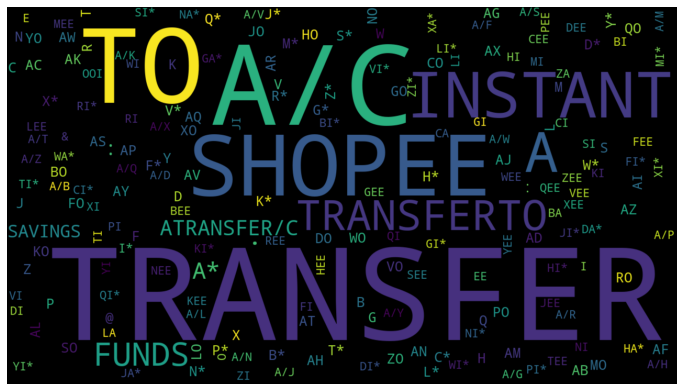

In [ ]:
# VISUALIZE WORD
word_freq = FreqDist(list_of_word)
viz_word_freq = WordCloud(width=1280, height=720).generate_from_frequencies(word_freq)

plt.figure(figsize=(12,8))
plt.imshow(viz_word_freq, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
def replace_bank_stmt(text):
  stmts = ['A/C', 'INSTANT', 'SHOPEE', 'TRANSFERTO', 'TRANSFER TO', 'ATRANSFER/C', 'TRANSFER', 'FUNDS', 'SAVINGS', '-', '\*']
  for stmt in stmts:
    text = re.sub(stmt, ' ', text)
  return text.strip()

In [ ]:
bank_statement_df['desc_cleaned'] = bank_statement_df['desc'].apply(lambda x: replace_bank_stmt(x))
bank_statement_df.head()

,stmt_id,stmt_amount,desc,desc_cleaned
0,1,100.00,INSTANT TRANSFER BAW CGANBAWI YIWHI * LEZC HXA * ZLLEZC FUNDSHXA -,BAW CGANBAWI YIWHI LEZC HXA ZLLEZC HXA
1,2,23.77,WOOG CARIZA NIWSI YO,WOOG CARIZA NIWSI YO
2,3,18.00,ZOMAZAW MABIX ATMA * BUGW * KZBUGW - TRANSFER TO A/C,ZOMAZAW MABIX ATMA BUGW KZBUGW
3,4,21.87,TRANSFER GO LA/FA AHHA PUYIMA * YEBF GNA * BFUNDSYYEBF GNA -,GO LA/FA AHHA PUYIMA YEBF GNA B YYEBF GNA
4,5,53.68,INSTANT TRANSFER FABZUN WIQAT JIW FA* TEGF PYA * ATTEGF FUNDSPYA -,FABZUN WIQAT JIW FA TEGF PYA ATTEGF PYA


## **Matching Process**

In [ ]:
bank_statement_df.tail()

,stmt_id,stmt_amount,desc,desc_cleaned
239995,239996,45.63,RV WC XUH AQLIXA GIXYI WAX,RV WC XUH AQLIXA GIXYI WAX
239996,239997,63.30,TRANSFER RO MA/BA EYEKIA AT GXAZMIB * YELB RXA * AFUNDSYYELB RXA -,RO MA/BA EYEKIA AT GXAZMIB YELB RXA A YYELB RXA
239997,239998,9.76,INSTANT TRANSFER PUZ JATITI WJAJIZAJ* TEDW HZA * DTTEDW FUNDSHZA -,PUZ JATITI WJAJIZAJ TEDW HZA DTTEDW HZA
239998,239999,145.00,WUVIJA XAJVISA FISD* SURWISZ POYER * AKSURWISZ POYER -,WUVIJA XAJVISA FISD SURWISZ POYER AKSURWISZ POYER
239999,240000,30.28,WEE BIAJ SUI * BCC QD-SHOPEE LV XALDZ TRANSFER * XBLV XALDZ - TO A/C,WEE BIAJ SUI BCC QD LV XALDZ XBLV XALDZ TO


In [ ]:
checkout_df.tail()

,ckt_id,ckt_amount,buyer_name
239995,329026,15.00,VAQFILAPA JIPTI NORABI
239996,329027,70.39,JIQI CUWAIVAC FIBQI IFVACIW
239997,329030,35.08,MFAFHIYAB JIYVI MFAQMUTTIY
239998,329031,20.62,VAHID DUBRQAVIBA JH FOQL ANAD
239999,329032,16.77,HAGOUF GOJBAQ


In [ ]:
# partial_ratio + data cleaning : 0.99830
# partial_ratio                 : 0.99702
# token_set_ratio               : 0.99130
# token_sort_ratio              : 0.91377
# wratio                        : 0.91313
# ratio                         : 0.91134
# qratio                        : 0.91134

def matcher(stmt_id, stmt_amount, desc):
  print('{}/240000'.format(stmt_id))
  same_amount_df = list(checkout_df[checkout_df['ckt_amount'] == stmt_amount]['buyer_name'])
  matching = rapidfuzz.process.extractOne(desc, same_amount_df, scorer=rapidfuzz.fuzz.partial_ratio)
  return matching[0], matching[1]

data_matched = bank_statement_df.apply(lambda x: matcher(x['stmt_id'], x['stmt_amount'], x['desc_cleaned']), axis=1)

In [ ]:
matched_df = bank_statement_df.copy(deep=True)
matched_df['buyer_name'] = data_matched.apply(lambda x: x[0])
matched_df = pd.merge(matched_df, checkout_df, how='left', left_on=['buyer_name','stmt_amount'], right_on=['buyer_name','ckt_amount'])
matched_df

,stmt_id,stmt_amount,desc,desc_cleaned,buyer_name,ckt_id,ckt_amount
0,1,100.00,INSTANT TRANSFER BAW CGANBAWI YIWHI * LEZC HXA * ZLLEZC FUNDSHXA -,BAW CGANBAWI YIWHI LEZC HXA ZLLEZC HXA,BAW CGANBAWI,37064,100.00
1,2,23.77,WOOG CARIZA NIWSI YO,WOOG CARIZA NIWSI YO,WOOG CARIZA NIWSI YORZ QAWIM,37067,23.77
2,3,18.00,ZOMAZAW MABIX ATMA * BUGW * KZBUGW - TRANSFER TO A/C,ZOMAZAW MABIX ATMA BUGW KZBUGW,ZOMAZAW MABIX ATMA,214638,18.00
3,4,21.87,TRANSFER GO LA/FA AHHA PUYIMA * YEBF GNA * BFUNDSYYEBF GNA -,GO LA/FA AHHA PUYIMA YEBF GNA B YYEBF GNA,AHHA PUYIMA,137482,21.87
4,5,53.68,INSTANT TRANSFER FABZUN WIQAT JIW FA* TEGF PYA * ATTEGF FUNDSPYA -,FABZUN WIQAT JIW FA TEGF PYA ATTEGF PYA,FABZUN WIQAT JIW FANNES,95564,53.68
...,...,...,...,...,...,...,...
239995,239996,45.63,RV WC XUH AQLIXA GIXYI WAX,RV WC XUH AQLIXA GIXYI WAX,XUH AQLIXA GIXYI WAXOHUCIX,144795,45.63
239996,239997,63.30,TRANSFER RO MA/BA EYEKIA AT GXAZMIB * YELB RXA * AFUNDSYYELB RXA -,RO MA/BA EYEKIA AT GXAZMIB YELB RXA A YYELB RXA,EYEKIA AZAT GXAZMIB,261800,63.30
239997,239998,9.76,INSTANT TRANSFER PUZ JATITI WJAJIZAJ* TEDW HZA * DTTEDW FUNDSHZA -,PUZ JATITI WJAJIZAJ TEDW HZA DTTEDW HZA,PUZ JATITI WJAJIZAJ NIPHI WJATWU NAJZI,177305,9.76
239998,239999,145.00,WUVIJA XAJVISA FISD* SURWISZ POYER * AKSURWISZ POYER -,WUVIJA XAJVISA FISD SURWISZ POYER AKSURWISZ POYER,WUVIJA XAJVISA,204590,145.00


In [ ]:
matched_df[matched_df['ckt_id'].duplicated()].sort_values(by=['ckt_id']).head(20)

,stmt_id,stmt_amount,desc,desc_cleaned,buyer_name,ckt_id,ckt_amount
109112,109113,45.00,INSTANT TRANSFER BINI LOF ANIVAX WIL* ZEJB NFA * JZZEJB FUNDSNFA -,BINI LOF ANIVAX WIL ZEJB NFA JZZEJB NFA,AIVAM,1243,45.00
214567,214568,45.00,VAVAAPID LAYABIAS TIKNI ATU T,VAVAAPID LAYABIAS TIKNI ATU T,AIVAM,1243,45.00
109516,109517,45.00,FUJAFAL JAIVAW JURA* INSTANT TRANSFER FEGT ZXA * GFFEGT FUNDSZXA - TO A/C,FUJAFAL JAIVAW JURA FEGT ZXA GFFEGT ZXA TO,AIVAM,1243,45.00
146624,146625,45.00,GAHIKA PIKJI MAMM Z* SHOPEE VAUM * RS VAUM -,GAHIKA PIKJI MAMM Z VAUM RS VAUM,AIVAM,1243,45.00
195471,195472,53.13,YAFUNA PITBI YAFFIN* DWGO * WNDWGO - TRANSFER TO A/C,YAFUNA PITBI YAFFIN DWGO WNDWGO,YAFUNA PITBI YAFFIN,2648,53.13
111398,111399,60.00,QOOV EVHA AWIYA XIQ* ROZZEE SHOPEE * AHROZZEE -,QOOV EVHA AWIYA XIQ ROZZEE AHROZZEE,NIRLEOZZCEE,2852,60.00
120090,120091,50.00,UKIRA JUI VUMR TRANSFER * AKVUMR -,UKIRA JUI VUMR AKVUMR,UKIRA JUI,5711,50.00
185002,185003,40.50,RHIX FEI RHUXQ * UDR * JBUDR -,RHIX FEI RHUXQ UDR JBUDR,LRI BUFARBI,6835,40.50
28027,28028,25.90,FEL ZDEI RUCARRAK AKCAY FIW * FEL ZDEI * ARFEL ZDEI -,FEL ZDEI RUCARRAK AKCAY FIW FEL ZDEI ARFEL ZDEI,CARXA,7922,25.90
109678,109679,15.90,GUJXQARIEG ANIMA BI* BACRAG DUIC WAXIGT * FRDUIC WAXIGT - TRANSFER TO A/C,GUJXQARIEG ANIMA BI BACRAG DUIC WAXIGT FRDUIC WAXIGT,ANIYA,8325,15.90


## **Matching Result**

In [ ]:
# matched_df = pd.read_csv('/content/drive/MyDrive/DataScience/Self Project/Payment Matching/dataset/matched_data.csv')
matched_df

,stmt_id,stmt_amount,desc,desc_cleaned,buyer_name,ckt_id,ckt_amount
0,1,100.00,INSTANT TRANSFER BAW CGANBAWI YIWHI * LEZC HXA * ZLLEZC FUNDSHXA -,BAW CGANBAWI YIWHI LEZC HXA ZLLEZC HXA,BAW CGANBAWI,37064,100.00
1,2,23.77,WOOG CARIZA NIWSI YO,WOOG CARIZA NIWSI YO,WOOG CARIZA NIWSI YORZ QAWIM,37067,23.77
2,3,18.00,ZOMAZAW MABIX ATMA * BUGW * KZBUGW - TRANSFER TO A/C,ZOMAZAW MABIX ATMA BUGW KZBUGW,ZOMAZAW MABIX ATMA,214638,18.00
3,4,21.87,TRANSFER GO LA/FA AHHA PUYIMA * YEBF GNA * BFUNDSYYEBF GNA -,GO LA/FA AHHA PUYIMA YEBF GNA B YYEBF GNA,AHHA PUYIMA,137482,21.87
4,5,53.68,INSTANT TRANSFER FABZUN WIQAT JIW FA* TEGF PYA * ATTEGF FUNDSPYA -,FABZUN WIQAT JIW FA TEGF PYA ATTEGF PYA,FABZUN WIQAT JIW FANNES,95564,53.68
...,...,...,...,...,...,...,...
239995,239996,45.63,RV WC XUH AQLIXA GIXYI WAX,RV WC XUH AQLIXA GIXYI WAX,XUH AQLIXA GIXYI WAXOHUCIX,144795,45.63
239996,239997,63.30,TRANSFER RO MA/BA EYEKIA AT GXAZMIB * YELB RXA * AFUNDSYYELB RXA -,RO MA/BA EYEKIA AT GXAZMIB YELB RXA A YYELB RXA,EYEKIA AZAT GXAZMIB,261800,63.30
239997,239998,9.76,INSTANT TRANSFER PUZ JATITI WJAJIZAJ* TEDW HZA * DTTEDW FUNDSHZA -,PUZ JATITI WJAJIZAJ TEDW HZA DTTEDW HZA,PUZ JATITI WJAJIZAJ NIPHI WJATWU NAJZI,177305,9.76
239998,239999,145.00,WUVIJA XAJVISA FISD* SURWISZ POYER * AKSURWISZ POYER -,WUVIJA XAJVISA FISD SURWISZ POYER AKSURWISZ POYER,WUVIJA XAJVISA,204590,145.00


In [ ]:
matched_df.to_csv("/content/drive/MyDrive/DataScience/Self Project/Payment Matching/dataset/matched_data.csv", index=False)

In [ ]:
matched_df[['stmt_id', 'ckt_id']].sort_values(by=['stmt_id']).to_csv("/content/drive/MyDrive/DataScience/Self Project/Payment Matching/dataset/submission.csv", index=False)

## ⛳ **Experiment Result**

|Scoring Methods|Score|
|:---|:---|
|partial_ratio + data cleaning|0.99830|
|partial_ratio                |0.99702|
|token_set_ratio              |0.99130|
|token_sort_ratio             |0.91377|
|wratio                       |0.91313|
|ratio                        |0.91134|
|qratio                       |0.91134|

# ***DRIVE LINK*** : https://drive.google.com/drive/folders/15i3cUkSPmbR6kDDBMDDNVswvQmSHzKCk?usp=sharing